In [1]:
import healpy as hp
import numpy as np
import os
from os import listdir
import matplotlib.pyplot as plt
import h5py
import numpy.ma as ma
from scipy import signal, stats
import sys

from scipy.optimize import curve_fit

ImportError: No module named healpy

In [2]:
%matplotlib notebook

In [3]:
def round_fraction(number, res):
    amount = int(number/res)*res
    remainder = number - amount
    return amount if remainder < res/2. else amount+res


In [4]:
def plotnow_azelsig(data, az, el, chan, var, res, minmax=None, radec=False, supply_index=False, return_map=False):
    # flp=select_h5(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    # fld_demod, fld =select_dat(fpath,yrmoday,st_hour,st_minute,ed_hour,ed_minute)
    # i=0
    # while len(flp)<3:
    #	i+=1
    #	flp=select_h5(fpath,yrmoday,st_hour,int(st_minute)-i,ed_hour,int(ed_minute)+i)

    # pp=get_h5_pointing(flp)
    ##dd=get_demodulated_data_from_list(fld,supply_index=supply_index)
    # dd=get_all_demodulated_data(fld_demod, fld)
    # combined=combine_cofe_h5_pointing(dd,pp)

    # synchronized data az and el values
    az1, el1 = az * 1, el * 1
    print(el1)
    data = data * 1

    # convert to temp for cryo sensors
    if chan == 12:
        data = convert.convert(data, 'i')
    if chan == 13:
        data = convert.convert(data, 'e')
    if chan == 14:
        data = convert.convert(data, 'h')
    if chan == 15:
        data = convert.convert(data, 'l')

    steps = len(data)

    # set az/el resolution
    dx = res
    dy = res

    # set up bins/grid
    if radec:
        x, y = np.arange(0., 360. + dx, dx), np.arange(-90., 90. + dy, dy)
    else:
        x, y = np.arange(0., 360. + dx, dx), np.arange(0., 90. + dy, dy)
    AZ, EL = np.meshgrid(x, y)

    # small number for comparing floats
    epsilon = 1e-6

    # set up matrix for signal
    z1 = np.zeros(len(x) * len(y))
    sig = np.reshape(z1, (len(y), len(x)))

    # set up matrix for keeping track of data points in single bin for averaging
    z2 = np.zeros(len(x) * len(y))
    count = np.reshape(z2, (len(y), len(x)))

    for i in range(steps):
        # round az/el points for comparison with grid
        el1[i] = round_fraction(el1[i], dy)
        az1[i] = round_fraction(az1[i], dx)

        # find where data points belong in grid
        iel = np.where(abs(y - el1[i]) < epsilon)[0][0]
        iaz = np.where(abs(x - az1[i]) < epsilon)[0][0]

        # add 1 each time data point lands in same bin
        count[iel][iaz] += 1

        # add total number of data values in bin
        sig[iel][iaz] = sig[iel][iaz] + data[i]

        # mask 0 count values so they dont show up in color plot
    count = ma.masked_where(count == 0.0, count)

    # take average of all data points in single bin
    sig = sig / count

    try:
        # change units on plot label
        if int(chan[2:]) < 12:
            unit = 'V'
        else:
            unit = 'K'

        name = rt.chantoname(chan)
    except:
        unit = 'C'
        name = chan

    if return_map:
        return AZ, EL, sig
    else:
        plt.pcolormesh(AZ, EL, sig, cmap='jet')
        plt.colorbar(label='Signal, %s' % unit)
        if minmax != None:
            plt.clim(minmax[0], minmax[1])
        else:
            plt.clim(data.min(), data.max())
        if radec == False:
            plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
            plt.ylabel('elevation (deg)')
            plt.xlabel('azimuth (deg)')
        else:
            plt.axis([0., 360., -90, 90.])
            plt.xlabel('ra (deg)')
            plt.ylabel('dec (deg)')
        plt.title('%s %s data binned to azimuth and elevation' % (name, var))
        plt.grid()
        plt.show()

In [5]:
#this is pointing to c drive, move destriped data there!
day = '28+30'
periods = 'night'
#folder = 'dst_out_H3AC_night_only_removed_rev_offsets_10%s2020_out_256' % day
folder = 'dst_out_1028+1030_night_only_lines_removed_out_256'
hitfile = '../../polaris_data/destriped/move/%s/hits.fits' % folder
mapfile = '../../polaris_data/destriped/move/%s/destriped.fits' % folder
binfile = '../../polaris_data/destriped/move/%s/bin.fits' % folder

In [6]:
NET = 1.11e-3
#for temperature make this 4.3 +\- 0.9
sampling_frequency = 33.97
gain = 1.24
gerror = 0.2*gain

In [7]:
hits = hp.read_map(hitfile)
hits[hits == 0.0] = hp.UNSEEN
T = hp.read_map(mapfile, field=0)
Q = hp.read_map(mapfile, field=1)
U = hp.read_map(mapfile, field=2)

binT = hp.read_map(binfile, field=0)
binQ = hp.read_map(binfile, field=1)
binU = hp.read_map(binfile, field=2)

#T[hits!=hp.UNSEEN] = T[hits!=hp.UNSEEN]*1e3
#Q[hits!=hp.UNSEEN] = Q[hits!=hp.UNSEEN]*1e3
#U[hits!=hp.UNSEEN] = U[hits!=hp.UNSEEN]*1e3

##binT[hits!=hp.UNSEEN] = binT[hits!=hp.UNSEEN]*1e3
#binQ[hits!=hp.UNSEEN] = binQ[hits!=hp.UNSEEN]*1e3
#binU[hits!=hp.UNSEEN] = binU[hits!=hp.UNSEEN]*1e3

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [8]:
time_per_pixel = (hits/sampling_frequency)
white_noise_level = 1.11e-3/(np.sqrt(time_per_pixel))
pix_size = hp.nside2resol(256)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [9]:
np.random.seed(0)
wn = np.random.normal(0,1,len(T))*white_noise_level
wn[hits == hp.UNSEEN] = hp.UNSEEN

In [10]:
def error(iterations, white_noise_level):
    noise_psd = []
    for i in range(iterations):
        np.random.seed(i)
        noise = np.random.normal(0,1,len(T))*white_noise_level
        noise[np.isnan(noise)] = hp.UNSEEN
        #noise[hits == hp.UNSEEN] = hp.UNSEEN
        noise_psd.append(hp.anafast(noise, alm = False))
        sys.stdout.write("\r percent complete: %.2f" % (100*i/iterations))
        sys.stdout.flush()
    noise_psd = np.asarray(noise_psd).T
    return noise_psd

In [11]:
noise_psd = error(100, white_noise_level)

 percent complete: 99.00

In [12]:
psd_error = np.asarray([n.std() for n in noise_psd])

In [13]:
IQU = [T, Q, U]
PSD = hp.anafast(IQU, alm = False)
#psd_nomd = hp.anafast(nomd, alm = False)
WN = hp.anafast(wn, alm = False)

In [14]:
psd = {'TT': PSD[0], 'EE': PSD[1], 'TE': PSD[3]}

In [15]:
iterations = 1
nside = 256
transfer = {}
for k in psd.keys():
    n = 0
    transfer[k] = np.zeros(len(psd[k]))
    while n < iterations: 
        np.random.seed(0)
        MAP = hp.synfast(psd[k], nside, verbose=False) #should include theoretical power spectrum here, look for tools to extrapolate 
        #planck maps, or use old tools you had to extrapolate individual foreground maps
    
        MAP = hp.smoothing(MAP, np.radians(1.3), verbose=False)

        MAP[hits == hp.UNSEEN] = hp.UNSEEN
        psdtrans = hp.anafast(MAP, alm=False)
        transfer[k] += psd[k]/psdtrans
        
        n += 1
        sys.stdout.write("\r iterations complete: %.2f" % (n))
        sys.stdout.flush()
    
    print('\n'+k+' complete')
    transfer[k] = transfer[k]/iterations

 iterations complete: 1.00
EE complete
 iterations complete: 1.00
TT complete
 iterations complete: 1.00
TE complete


<IPython.core.display.Javascript object>


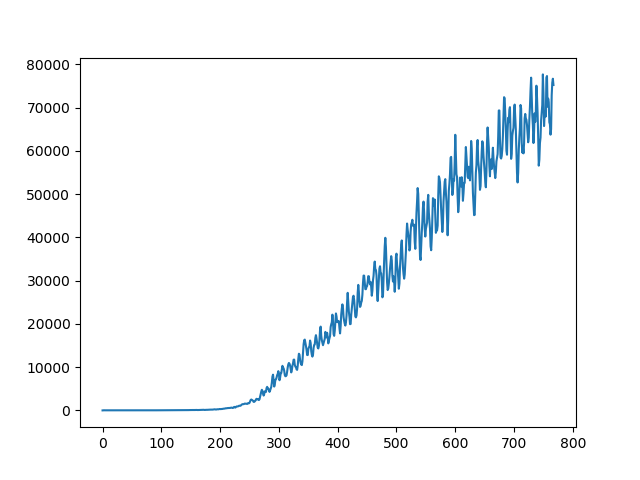

In [16]:
plt.figure()
plt.plot(transfer['EE'])

In [17]:
l = np.arange(0,len(psd['TT']))

<IPython.core.display.Javascript object>


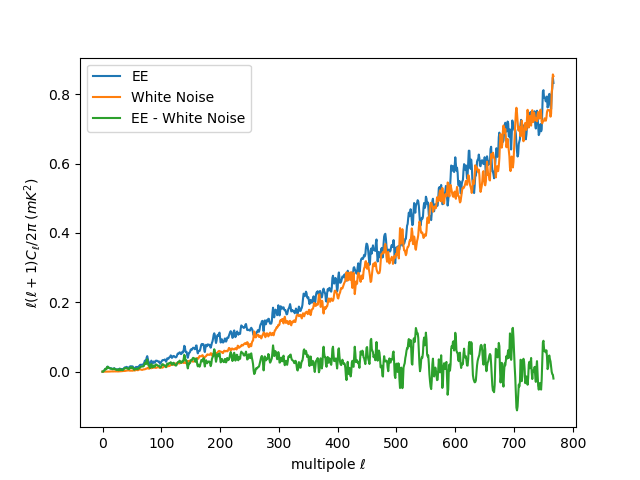

In [19]:
k = 'EE'
plt.figure()
y1 = 1000**2*l*(l+1)*psd[k]/2/np.pi
plt.plot(l, y1, label='EE')
y2 = 1000**2*l*(l+1)*WN/2/np.pi
plt.plot(l, y2, label = 'White Noise')
plt.plot(l, y1-y2, label=k+' - White Noise')
#plt.xlabel('samples')
#plt.ylabel('signal (K)')
plt.legend()
plt.ylabel('$\ell(\ell+1)C_{\ell}/2\pi$ $(mK^2)$')
plt.xlabel('multipole $\ell$')

<IPython.core.display.Javascript object>


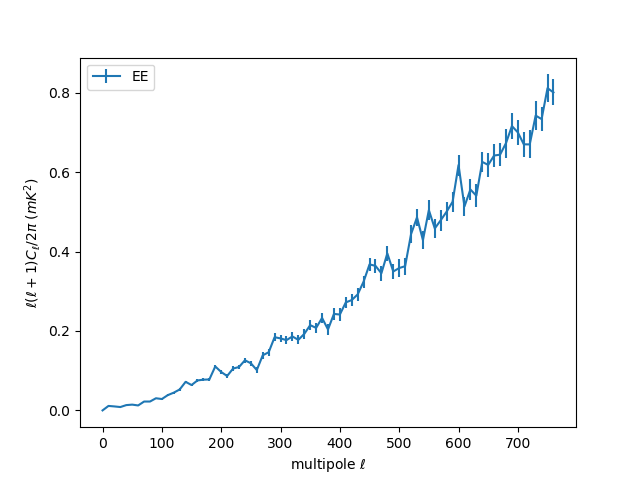

In [21]:
k = 'EE'
plt.figure()
y = 1000**2*l*(l+1)*psd[k]/2/np.pi
yerr = 1000**2*l*(l+1)*(psd_error + psd_error*(0.22)**2)/2/np.pi #how do i add the gain error here, i cant just add it linearly and square it because the units arent the same
plt.errorbar(l[0::10], y[0::10], yerr=yerr[0::10], fmt='-', label='EE')
#plt.xlabel('samples')
#plt.ylabel('signal (K)')
plt.legend()
plt.ylabel('$\ell(\ell+1)C_{\ell}/2\pi$ $(mK^2)$')
plt.xlabel('multipole $\ell$')

In [240]:
NET = 1.3e-3
sampling_frequency = 33.97
gain = -1.24

In [241]:
hits[hits == 0.0] = hp.UNSEEN

In [242]:
hittotal = (hits[hits!=hp.UNSEEN].sum())
timetotal = (hits[hits!=hp.UNSEEN].sum()/sampling_frequency/3600.)

print(hittotal, timetotal)

(1384000.0, 11.317175285382527)


<IPython.core.display.Javascript object>


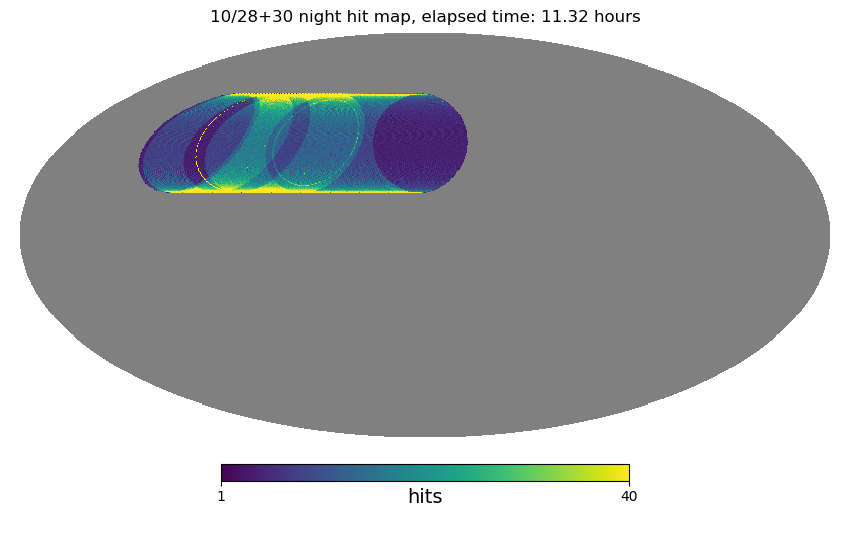

In [160]:
hp.mollview(hits, max=40, unit='hits', title='10/%s %s hit map, elapsed time: %.2f hours' % (day, periods, timetotal))
#plt.savefig('../../polaris_data/destriped/move/%s/hits.png' % folder, facecolor = 'w', transparent = False)

<IPython.core.display.Javascript object>


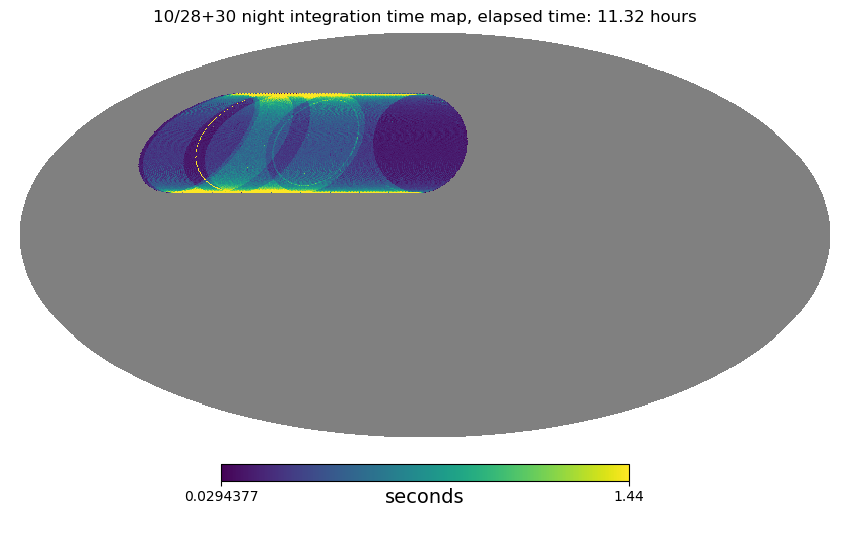

In [144]:
inttime = (hits/sampling_frequency)
inttime[inttime==inttime.min()] = hp.UNSEEN
etime = 0.0004*3600
hp.mollview(inttime, max=etime, unit='seconds', title='10/%s %s integration time map, elapsed time: %.2f hours' % (day, periods, timetotal))
#plt.savefig('../../polaris_data/destriped/move/%s/inttime.png' % folder, facecolor = 'w', transparent = False)

In [246]:
sensitivity = NET/np.sqrt(hits/sampling_frequency)

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [247]:
sensitivity

array([nan, nan, nan, ..., nan, nan, nan])

<IPython.core.display.Javascript object>


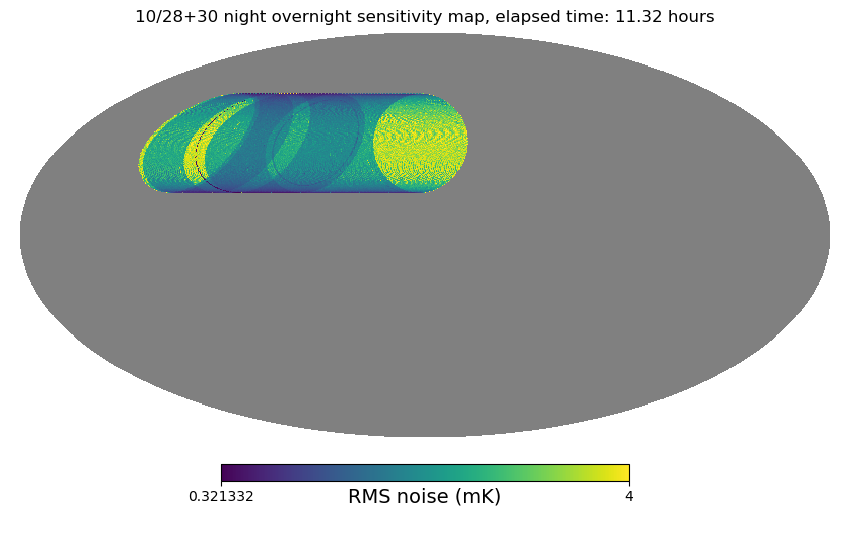

In [250]:
hp.mollview(1000*sensitivity, max = 4, unit='RMS noise (mK)', title='10/%s %s overnight sensitivity map, elapsed time: %.2f hours' % (day, periods, timetotal))
#plt.savefig('../../polaris_data/destriped/move/%s/sensitivity.png' % folder, facecolor = 'w', transparent = False)

<IPython.core.display.Javascript object>


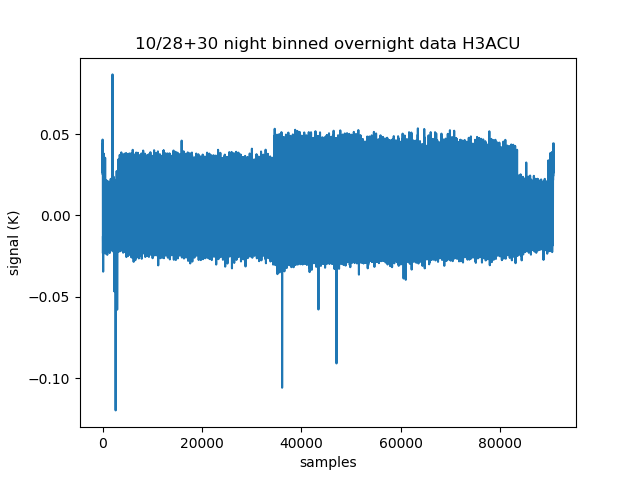

In [60]:
plt.figure()
var = 'U'
plt.plot(binU[binU!=hp.UNSEEN])
plt.xlabel('samples')
plt.ylabel('signal (K)')
plt.title('10/%s %s binned overnight data H3AC%s' % (day, periods, var))
#plt.savefig('../../polaris_data/destriped/move/%s/binned_signal%s_TOI.png' % (folder, var), facecolor = 'w', transparent = False)

<IPython.core.display.Javascript object>


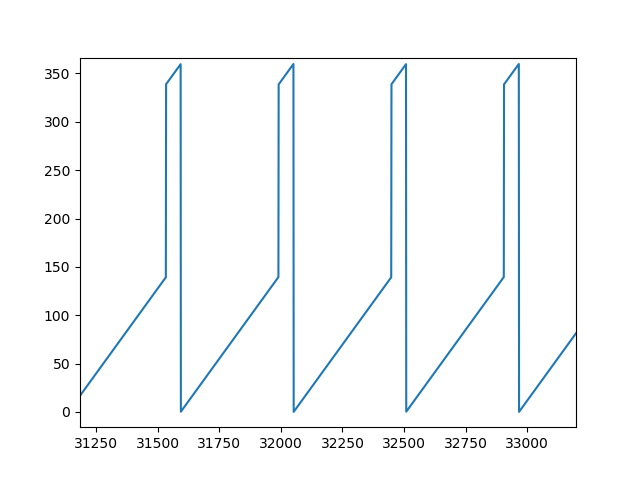

In [23]:
igood = np.where(Q!=hp.UNSEEN)[0]
theta, phi = hp.pix2ang(256, igood)
plt.figure()
plt.plot(np.degrees(phi))

<IPython.core.display.Javascript object>


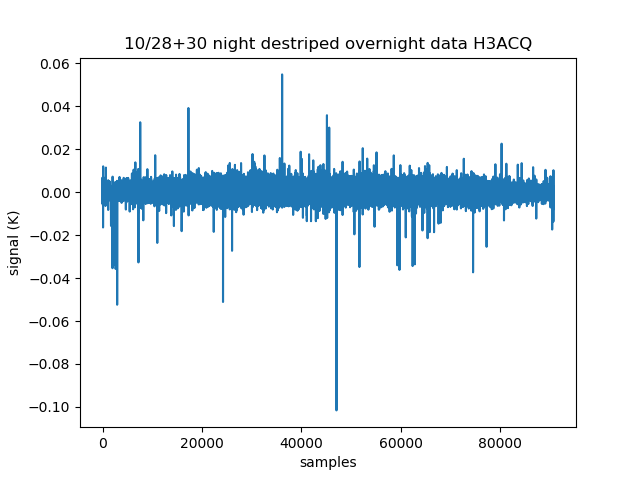

In [24]:
plt.figure()
var = 'Q'
plt.plot(Q[U!=hp.UNSEEN])
plt.xlabel('samples')
plt.ylabel('signal (K)')
plt.title('10/%s %s destriped overnight data H3AC%s' % (day, periods, var))
#plt.savefig('../../polaris_data/destriped/move/%s/destriped_signal%s_TOI.png' % (folder, var), facecolor = 'w', transparent = False)

In [25]:
Qtest = Q*1
Qtest[igood[71789:]] = hp.UNSEEN

<IPython.core.display.Javascript object>


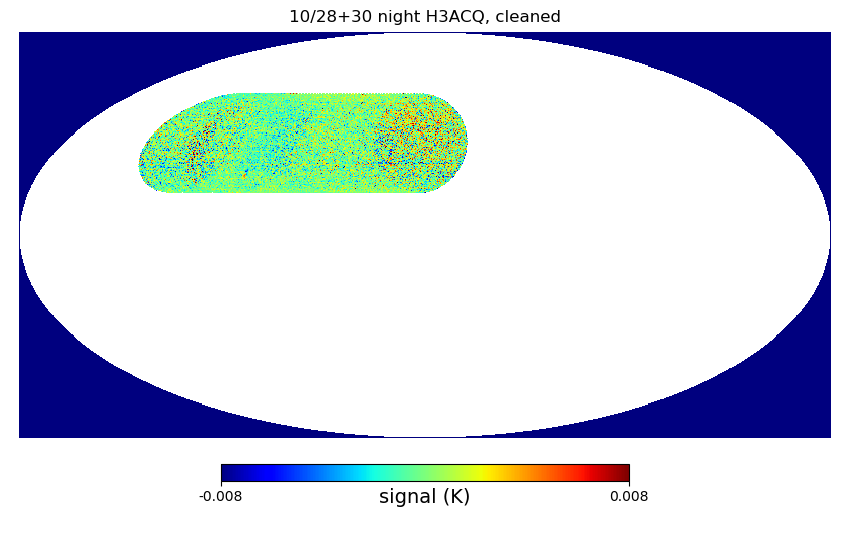

In [26]:
val = 0.008
#hp.mollview(Qtest, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s H3ACQ, cleaned' % (day, periods))
hp.mollview(Q, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s H3ACQ, cleaned' % (day, periods))

#plt.savefig('../../polaris_data/destriped/move/%s/signalQ.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

<IPython.core.display.Javascript object>


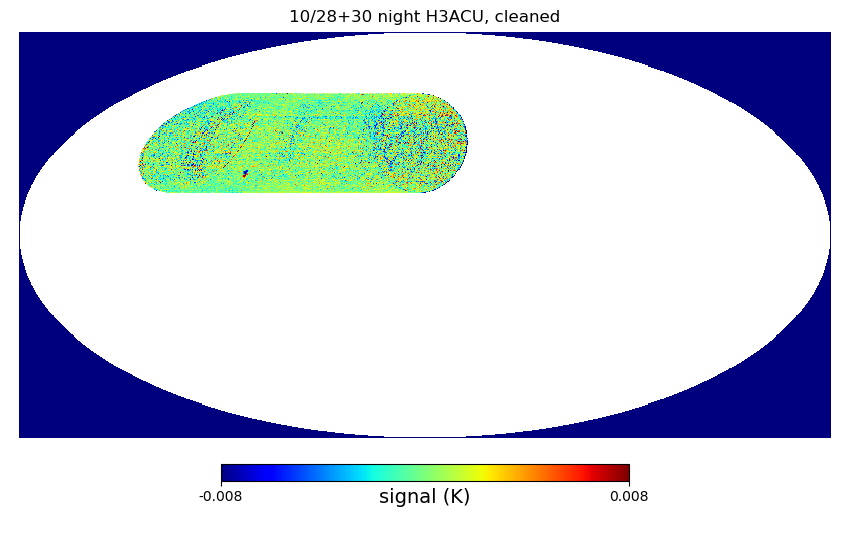

In [57]:
val = 0.008
hp.mollview(U, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s H3ACU, cleaned' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/signalU.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

<IPython.core.display.Javascript object>


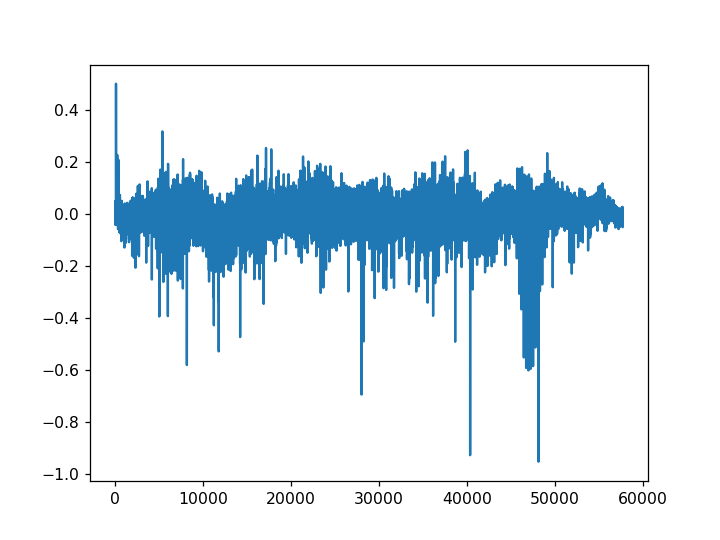

In [11]:
plt.figure()
plt.plot(T[T!=hp.UNSEEN])

<IPython.core.display.Javascript object>


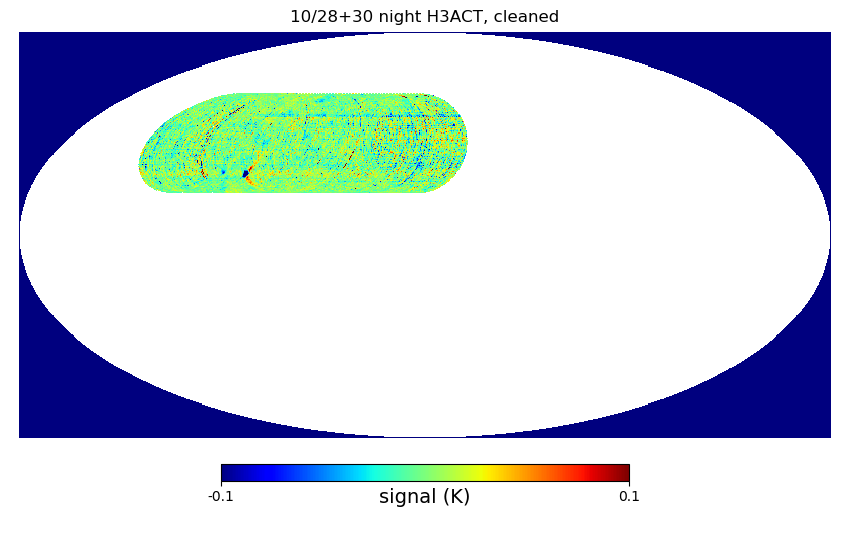

In [28]:
val = 0.1
hp.mollview(T, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s H3ACT, cleaned' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/signalT.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

<IPython.core.display.Javascript object>


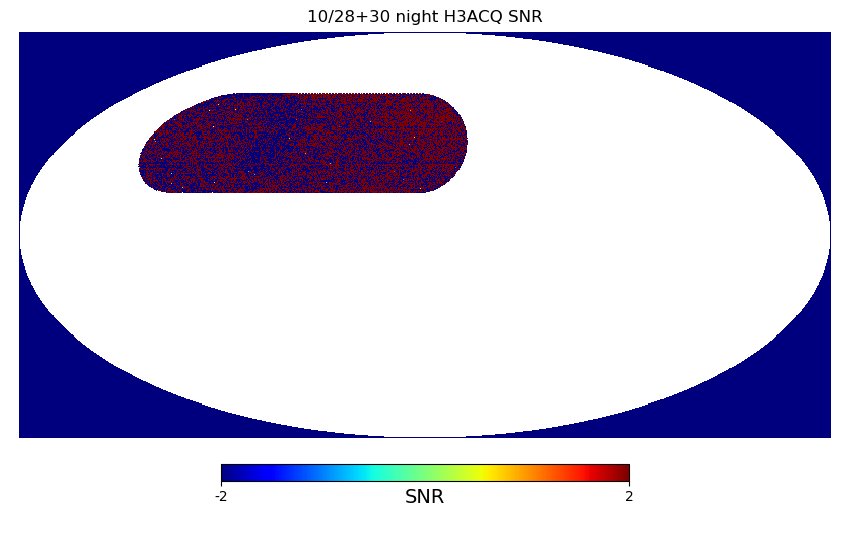

In [29]:
val = 0.002/1e-3
hp.mollview(Q/sensitivity/1e-3, min = -val, max = val, unit='SNR', cmap ='jet', title='10/%s %s H3ACQ SNR' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/SNRQ.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

<IPython.core.display.Javascript object>


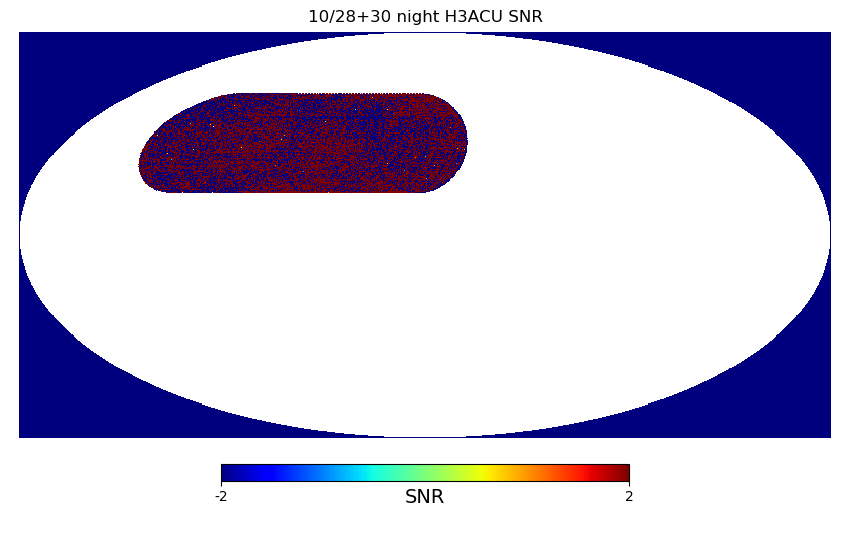

In [30]:
val = 0.002/1e-3
hp.mollview(U/sensitivity/1e-3, min = -val, max = val, unit='SNR', cmap ='jet', title='10/%s %s H3ACU SNR' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/SNRU.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

<IPython.core.display.Javascript object>


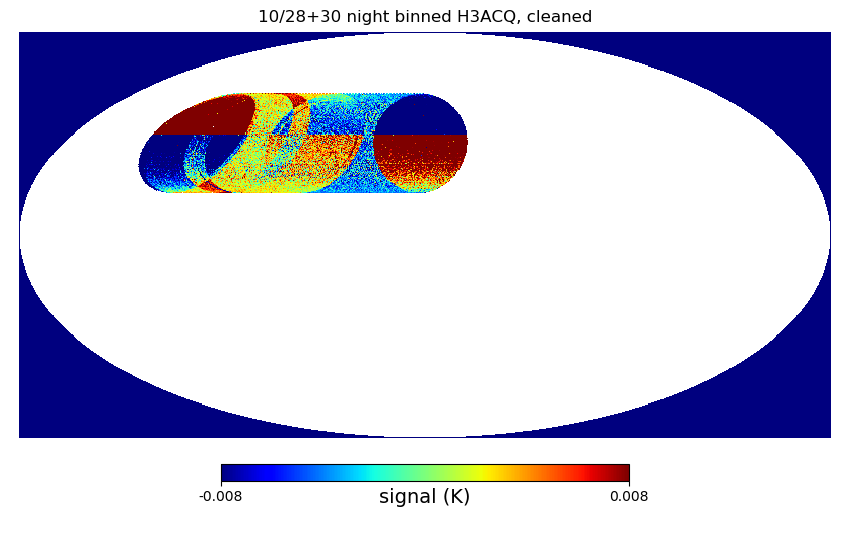

In [31]:
val = 0.008
hp.mollview(binQ, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s binned H3ACQ, cleaned' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/binned_signalQ.png' % folder, facecolor = 'w', transparent = False)
#plt.show()

<IPython.core.display.Javascript object>


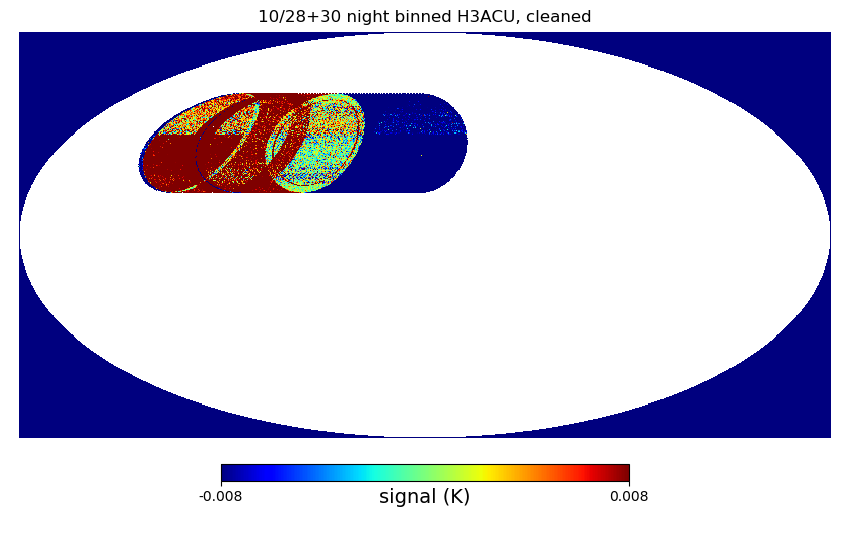

In [32]:
val = 0.008
hp.mollview(binU, min = -val, max = val, unit='signal (K)', cmap ='jet', title='10/%s %s binned H3ACU, cleaned' % (day, periods))
#plt.savefig('../../polaris_data/destriped/move/%s/binned_signalU.png' % folder, facecolor = 'w', transparent = False)
plt.show()

<IPython.core.display.Javascript object>


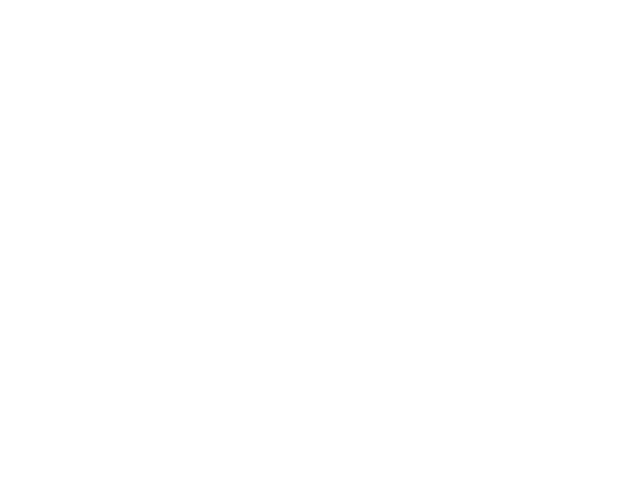

<IPython.core.display.Javascript object>


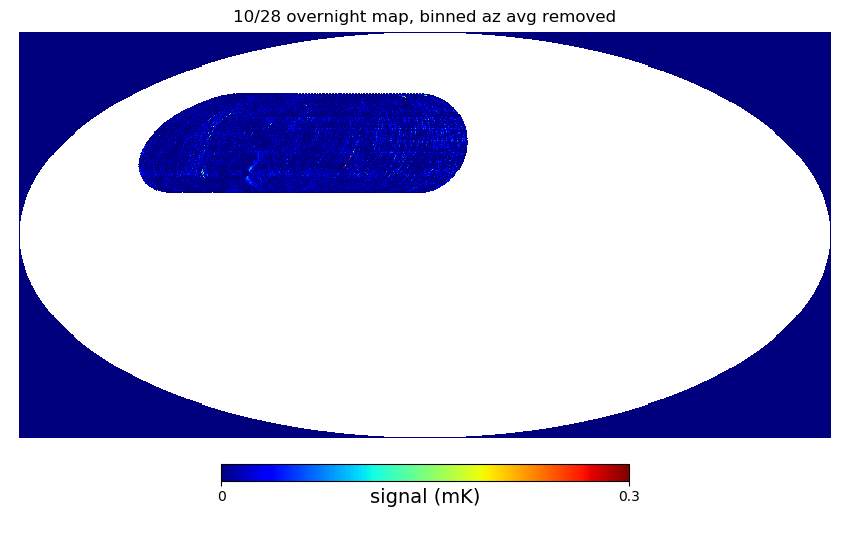

In [33]:
plt.figure()
vmin = 0.0
vmax = 0.3
#hp.mollview(sensitivity, max = 4., unit='RMS noise (mK)', title='10/28 overnight sensitivity map')
hp.mollview(T, min = vmin, max = vmax, unit='signal (mK)', title='10/28 overnight map, binned az avg removed', cmap='jet')

In [35]:
f = '../../polaris_data/level1/sedgwick/2020/20201028/old/H3AC_night_only_az_mean_removed.h5'
data=h5py.File(f)['data']

In [50]:
Tdata = data['TEMP']
Qdata = data['Q']
Udata = data['U']
ra = np.degrees(data['PHI'])
dec = np.degrees(np.pi/2. - data['THETA'])

phi = data['PHI']
theta = data['THETA']


In [37]:
print(len(data))

460342


<IPython.core.display.Javascript object>


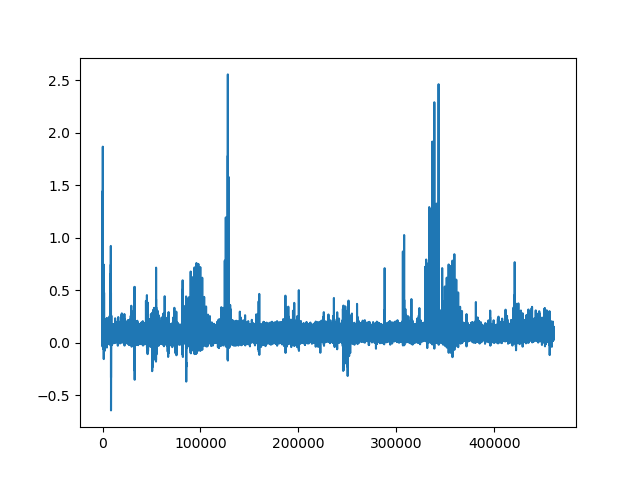

In [38]:
plt.figure()
plt.plot(Tdata)

In [46]:
RA, DEC, sig = plotnow_azelsig(Tdata, ra, dec, 'ch8', 'T', 0.5, minmax=None, radec=True, return_map=True)

[20.71940043 20.74437335 20.77294397 ... 44.55545497 44.61074547
 44.67085494]


/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


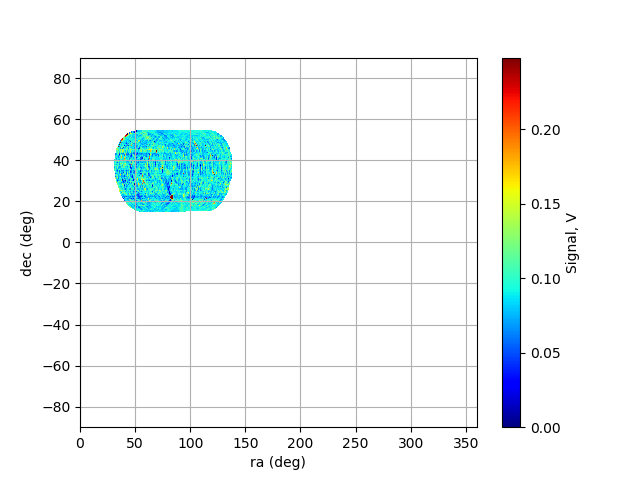

In [47]:
plt.figure()
plt.pcolormesh(RA, DEC, sig, cmap='jet')
plt.colorbar(label = 'Signal, V')
vmin = 0.0
vmax = 0.2*1.24
plt.clim(vmin,vmax)
radec=True
if radec == False:
    plt.axis([AZ.min(), AZ.max(), EL.min(), EL.max()])
    plt.ylabel('elevation (deg)')
    plt.xlabel('azimuth (deg)')
else:
    plt.axis([0., 360., -90, 90.])
    plt.xlabel('ra (deg)')
    plt.ylabel('dec (deg)')
#plt.title('%s %s removed binned az mean' % (chan, var))
plt.grid()
plt.show()

In [48]:
ramin = 82.
ramax = 86.
decmin = 21.
decmax = 23.5

data_crab = Tdata[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)][:2992]
ra_crab = ra[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)][:2992]
dec_crab = dec[(ra>ramin) & (ra<ramax) & (dec>decmin) & (dec<decmax)][:2992]

<IPython.core.display.Javascript object>


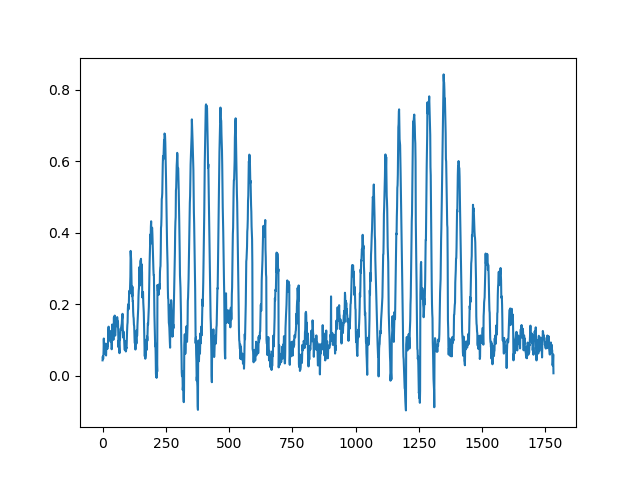

In [49]:
plt.figure()
plt.plot(data_crab)

In [43]:
Tmax = data_crab.max()
ramax = ra_crab[data_crab==Tmax]
decmax = dec_crab[data_crab==Tmax]
print(ramax, decmax)

(array([83.63748037]), array([22.56463292]))


<IPython.core.display.Javascript object>


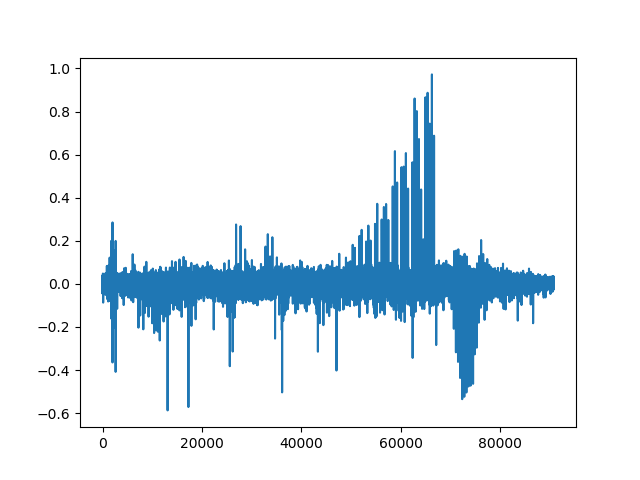

In [44]:
plt.figure()
plt.plot(T[T != hp.UNSEEN])

<IPython.core.display.Javascript object>


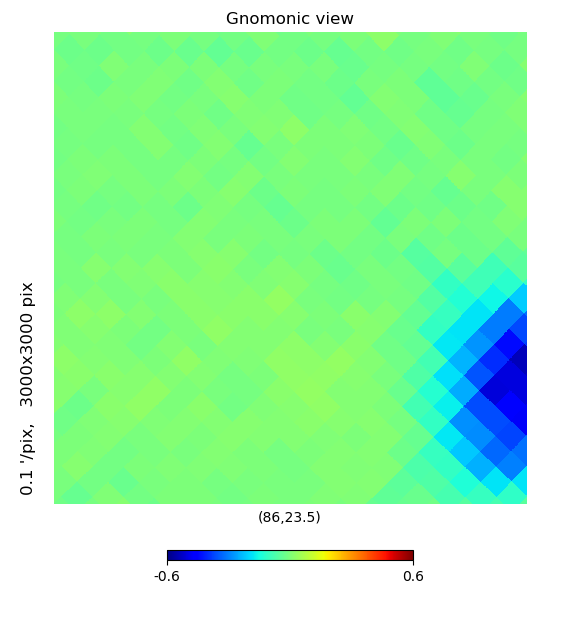

In [51]:
res = 0.1
xsize = 300/res
gmap = hp.gnomview(T, min=-0.6, max=0.6, reso=res, xsize=xsize, rot=(ramax, decmax, 0.), return_projected_map=True, cmap='jet')
#plt.savefig('../../polaris_software/data_acquisition/plots/acq_tel_plots/sedgwick/2020/gnomview_tauA_20201029.png', facecolor = 'w', transparent = False)

In [52]:
rarange = xsize*res/60.
print(rarange)

5.0


In [53]:
x = np.linspace(ramax-rarange/2.,ramax+rarange/2.,int(xsize))
y = np.linspace(decmax-rarange/2.,decmax+rarange/2.,int(xsize))
x,y = np.meshgrid(x,y)

In [54]:

dra = gmap[abs(y[:,0]-decmax)<res/60.].flatten()
raline = x[abs(y[:,0]-decmax)<res/60.].flatten()
#res = 0.2
#dra = data_crab[abs(dec_crab - decmax) <= res]
#raline = ra_crab[abs(dec_crab - decmax) <= res]

#ddec = data_crab[abs(ra_crab - ramax) <= res]
#decline = dec_crab[abs(ra_crab - ramax) <= res]

rasort = np.argsort(raline)
dra = dra[rasort]
raline = raline[rasort]

#decsort = np.argsort(decline)
#ddec = ddec[decsort]
#decline = decline[decsort]

In [55]:
def func(ra, o, A, mu, sig):
    return o + A*np.exp(-(ra-mu)**2 / 2 / sig**2)

In [56]:
rapopt, rapcov = curve_fit(func, raline, dra ,p0=[0.6, 0.76, 13., 1.0])
raoffset, raamplitude, ramean, rastd = rapopt
rafwhm = 2*rastd*np.sqrt(2*np.log(2))
raerr = np.sqrt(np.diag(rapcov))
rafwhmerr = 2*raerr[-1]*np.sqrt(2*np.log(2))

print('RA profile:')
print('offset: %.2f K' % raoffset)
print('Amplitude: %.2f K' % raamplitude)
print('True Signal Amplitude: %.2f K' % (raamplitude - raoffset))
print('Mean: %.2f K' % ramean)
print('Standar Deviation: %.2f K' % rastd)
print('FWHM: %.2f +/- %.4f deg' % (rafwhm, rafwhmerr))
print('-------------------------')

'''
decpopt, decpcov = curve_fit(func, decline, ddec ,p0=[0.085, 0.67, 22.2, 1.0])
decoffset, decamplitude, decmean, decstd = decpopt
decfwhm = 2*decstd*np.sqrt(2*np.log(2))

print 'DEC profile'
print 'offset: %.2f K' % decoffset
print 'Amplitude: %.2f K' % decamplitude
print 'True Signal Amplitude: %.2f K' % (decamplitude - decoffset)
print 'Mean: %.2f K' % decmean
print 'Standar Deviation: %.2f K' % decstd
print r'FWHM: %.2f deg' % decfwhm
print '-------------------------'
print 'Avg Signal Amplitude: %.2f K' % (((decamplitude - decoffset)+(raamplitude - raoffset))/2.)
'''

RA profile:
offset: -0.01 K
Amplitude: 0.76 K
True Signal Amplitude: 0.77 K
Mean: 13.00 K
Standar Deviation: 1.00 K
FWHM: 2.35 +/- inf deg
-------------------------


/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


"\ndecpopt, decpcov = curve_fit(func, decline, ddec ,p0=[0.085, 0.67, 22.2, 1.0])\ndecoffset, decamplitude, decmean, decstd = decpopt\ndecfwhm = 2*decstd*np.sqrt(2*np.log(2))\n\nprint 'DEC profile'\nprint 'offset: %.2f K' % decoffset\nprint 'Amplitude: %.2f K' % decamplitude\nprint 'True Signal Amplitude: %.2f K' % (decamplitude - decoffset)\nprint 'Mean: %.2f K' % decmean\nprint 'Standar Deviation: %.2f K' % decstd\nprint r'FWHM: %.2f deg' % decfwhm\nprint '-------------------------'\nprint 'Avg Signal Amplitude: %.2f K' % (((decamplitude - decoffset)+(raamplitude - raoffset))/2.)\n"

In [162]:
measured_tau_ra = func(raline, *rapopt)- raoffset

<IPython.core.display.Javascript object>


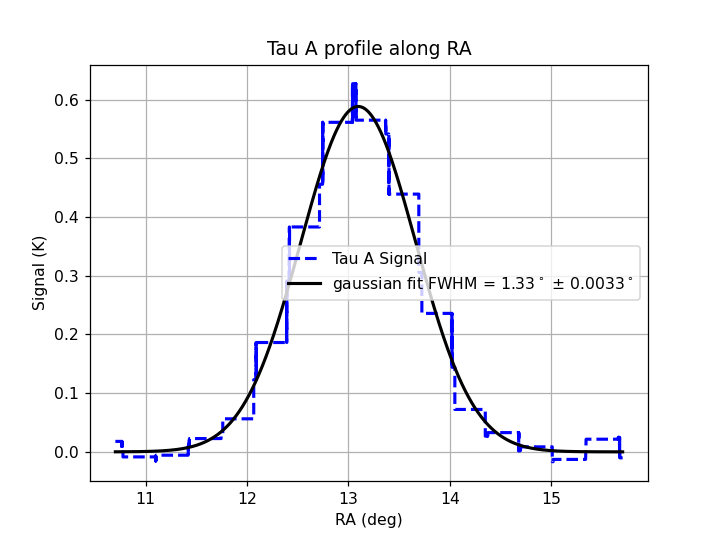

In [164]:
plt.figure()
plt.plot(raline, dra-raoffset, 'b--', linewidth=2, label='Tau A Signal')
plt.plot(raline, measured_tau_ra, 'k-', linewidth=2, label='gaussian fit FWHM = %.2f$^\circ$ $\pm$ %.4f$^\circ$' % (rafwhm, rafwhmerr))
plt.title('Tau A profile along RA')
plt.xlabel('RA (deg)')
plt.ylabel('Signal (K)')
plt.legend()
plt.grid()
plt.savefig('../../polaris_software/data_acquisition/plots/acq_tel_plots/sedgwick/2020/gnomview_tauA_gaussian_fit_20201111.png', facecolor = 'w', transparent = False)

In [171]:
tau_fwhm = 0.1
tau_std = tau_fwhm/2./np.sqrt(2*np.log(2))
dtau = func(raline, 0., raamplitude, ramean, tau_std)

imax = np.where(dtau == dtau.max())[0]

db = 0.0001
dev = 0.04
mean_guess = 1.33
beams = np.arange(mean_guess-dev, mean_guess+dev+db, db)
chi2min = 1e6
chisquared = []
for b in beams:
    #guess at beam size and make profile
    beam_fwhm = b
    beam_std = beam_fwhm/2./np.sqrt(2*np.log(2))
    dbeam = func(raline, 0., raamplitude, ramean, beam_std)

    dconvolved = np.convolve(dtau, dbeam, 'same')

    popt, cov = curve_fit(func, raline, dconvolved ,p0=[0.07, 0.66, 13., 1.0])
    offset, amplitude, mean, std = popt
    fwhm = 2*std*np.sqrt(2*np.log(2))
    convolved_fit = (func(raline, offset, amplitude, ramean, std) - offset)*raamplitude/amplitude
    
    chi2, p = stats.chisquare(convolved_fit, measured_tau_ra) 
    chisquared.append(chi2)
    
    if chi2 < chi2min:
        chi2min = chi2
        beamwidth = b
        pmin = p
        
chisqaured = np.array(chisquared)

In [172]:
print(100*(1.332-1.291)/1.332)

3.078078078078089


<IPython.core.display.Javascript object>


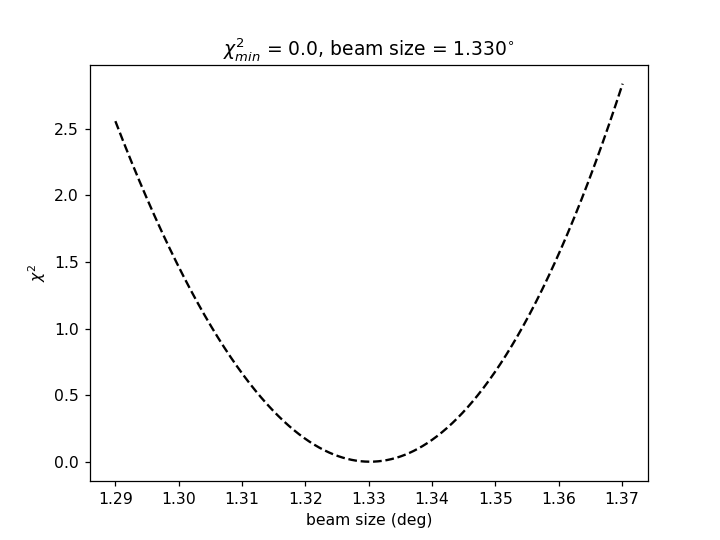

In [173]:
plt.figure()
plt.plot(beams, chisquared, 'k--')
plt.xlabel('beam size (deg)')
plt.ylabel('$\chi^2$')
plt.title('$\chi^2_{min}$ = %.1f, beam size = %.3f$^{\circ}$' % (chi2min, beamwidth))
plt.savefig('../../polaris_software/data_acquisition/plots/acq_tel_plots/sedgwick/2020/gnomview_tauA_chi2_20201111.png', facecolor = 'w', transparent = False)

In [179]:
a = np.array([1.332, 1.291, 1.276, 1.330])
print(a.std())
print(a.mean())

0.02434517405975981
1.30725
